# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [1]:
import matplotlib.pyplot as plt
import random

In [2]:
import numpy as np
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [3]:
def mse(y_true, y_predicted):
    return (np.sum((y_predicted - y_true)**2)) / len(y_true)

In [4]:
class LinReg:
    def __init__(self, alpha=0):
        self.alpha = alpha
    
    def fit(self, X, y):
        X_with_ones = np.ones((X.shape[0], X.shape[1]+1))
        X_with_ones[:,:-1] = X
        X = X_with_ones
        self.w = np.linalg.inv(np.dot(X.T, X) + self.alpha*np.eye(X.shape[1])) @ X.T @ y
        
    def predict(self, X):
        X_with_ones = np.ones((X.shape[0], X.shape[1]+1))
        X_with_ones[:,:-1] = X
        X = X_with_ones
        return X @ self.w

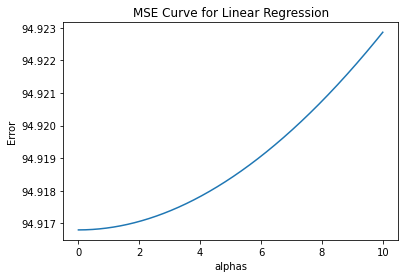

In [5]:
alphas = np.linspace(0,10,1000)
errors = []
for alpha in alphas:
    regr = LinReg(alpha=alpha)
    regr.fit(X, Y)
    errors.append(mse(Y, regr.predict(X)))
plt.figure()
plt.plot(alphas, errors)
plt.title('MSE Curve for Linear Regression')
plt.xlabel('alphas')
plt.ylabel('Error')
plt.show()

In [6]:
def k_fold_split(n, k):
    fold_indeces = np.arange(n) 
    fold_indeces = np.split(fold_indeces, k)
    return np.array(fold_indeces)

In [7]:
def validation_curve(X, y, k, alphas):
    indeces = k_fold_split(len(y), k)
    fold_list = np.arange(k)
    

    train_errors = []
    validation_errors = []
    for alpha in alphas:
        tr_errors = np.zeros(k)
        val_errors = np.zeros(k)
        for i in range(k):
            regr = LinReg(alpha=alpha)
            tr_indeces = indeces[np.delete(fold_list, i)].ravel()
            val_indeces = indeces[i].ravel()
            regr.fit(X[tr_indeces], y[tr_indeces])
            
            tr_errors[i] = mse(y[tr_indeces], regr.predict(X[tr_indeces]))
            val_errors[i] = mse(y[val_indeces], regr.predict(X[val_indeces]))
        train_errors.append(tr_errors)
        validation_errors.append(val_errors)
    return np.mean(train_errors, axis = 1 ), np.mean(validation_errors, axis = 1)

In [8]:
k = 5

In [9]:
Y = np.reshape(Y, (len(Y), 1))
XX = np.concatenate((X, Y), axis=1)
np.random.shuffle(XX) 
X_shuffled, Y_shuffled = XX[:,:-1], XX[:,-1]

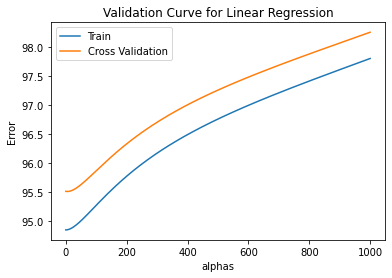

best alpha:  5.1931499365902125


In [10]:
alphas = np.logspace(-2, 3, 500)
train_errors, validation_errors = validation_curve(X_shuffled, Y_shuffled, k, alphas)
plt.figure()
plt.plot(alphas, train_errors)
plt.plot(alphas,  validation_errors)
plt.title('Validation Curve for Linear Regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('alphas')
plt.ylabel('Error')
plt.show()
best_alpha = alphas[np.argmin(validation_errors)]
print('best alpha: ', best_alpha)

In [11]:
def learning_curve(X, y, k, alpha):
    indeces = k_fold_split(len(y), k)
    fold_list = np.arange(k)
    
    train_errors = []
    validation_errors = []
    for j in range(indeces.shape[1]*(k-1)):
        tr_errors = np.zeros(k)
        val_errors = np.zeros(k)
        for i in range(k):
            regr = LinReg(alpha=alpha)
            tr_indeces = indeces[np.delete(fold_list, i)].ravel()
            val_indeces = indeces[i].ravel()
            x_i = X[tr_indeces][:j+1]
            y_i = y[tr_indeces][:j+1]
            x_val = X[val_indeces]
            y_val = y[val_indeces]
            regr.fit(x_i, y_i)
            
            tr_errors[i] = mse(y_i, regr.predict(x_i))
            val_errors[i] = mse(y_val, regr.predict(x_val))
        train_errors.append(tr_errors)
        validation_errors.append(val_errors)
    return np.mean(train_errors, axis=1), np.mean(validation_errors, axis=1)

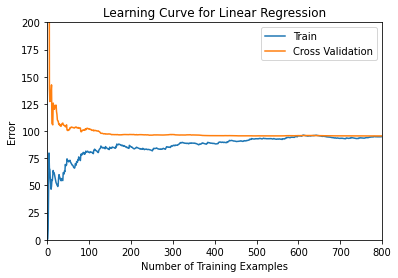

In [12]:
error_train, error_val = learning_curve(X_shuffled, Y_shuffled, k, best_alpha)
m = len(X_shuffled) / k * (k - 1)

plt.figure()
plt.plot(np.arange(m), error_train)
plt.plot(np.arange(m),  error_val)
plt.title('Learning Curve for Linear Regression')
plt.legend(['Train', 'Cross Validation'])
plt.xlabel('Number of Training Examples')
plt.ylabel('Error')
plt.axis([0, m, 0, 200])
plt.show()